In [ ]:
import torch
import torch.nn as nn
import argparse
from tqdm import tqdm

#### Load Autoregressive Flow-SSN checkpoint

In [ ]:
ckpt = torch.load('./ar_flowssn_lidc.pt')
args = argparse.Namespace(**ckpt["args"])

#### Load LIDC-IDRI dataset

In [11]:
from flowssn.data.lidc import get_lidc, preprocess_lidc_fn

datasets = get_lidc(args)
dataloader = torch.utils.data.DataLoader(
    datasets["test"],
    batch_size=12,
    shuffle=True,
    drop_last=False,
    num_workers=4
)

Loading LIDC train:
images: (9931, 1, 128, 128), masks: (9931, 4, 128, 128)
Loading LIDC val:
images: (2177, 1, 128, 128), masks: (2177, 4, 128, 128)
Loading LIDC test:
images: (2988, 1, 128, 128), masks: (2988, 4, 128, 128)


#### Load model

In [12]:
from flowssn.factory import build_nn
from flowssn.utils import count_params
from flowssn.models.autoregressive.model import AutoregressiveFlowSSN

base_net = None
if args.base_net != "" and args.cond_base:
    base_net, _ = build_nn(args.base_net, args=args, prefix="base_")

assert args.model == "ar-flowssn"

iaf_nets = nn.ModuleList()
for _ in range(args.num_flows):
    iaf_nets.append(build_nn(args.net, args=args)[0])
flow_nets = {"iaf": iaf_nets}

model = AutoregressiveFlowSSN(
    flow_type=args.flow_type,
    flow_nets=flow_nets,
    base_nets=(None if base_net is None else nn.ModuleDict({"iaf": base_net})),
    cond_flow=args.cond_flow,
    cond_base=args.cond_base,
    base_std=args.base_std,
    num_classes=args.num_classes,
)

model.load_state_dict(ckpt["model_state_dict"])
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);
model.eval()
print(
    f"#base params: {0 if model.base_nets is None else count_params(model.base_nets):,}\n" \
    + f"#flow params: {count_params(model.flows):,}\n" \
    + f"#total params: {count_params(model):,}"
)

#base params: 14,290,660
#flow params: 345,432
#total params: 14,636,092


#### Reproduce results in the paper

In [26]:
from flowssn.train import eval_batch

keys = ["energy_distance", "diversity", "hmiou", "dice"]
metrics = {k: 0.0 for k in keys}  # accumulated metrics
counts = {k: 0.0 for k in keys}  # non-nan value counters
loader = tqdm(dataloader, total=len(dataloader))

model.eval_samples = 100  # MC samples

with torch.no_grad():
    for batch in loader:
        bs = batch["x"].shape[0]
        batch = preprocess_lidc_fn(batch, device=device)

        out = model.forward({"x": batch["x"]}, model.eval_samples)
        probs = out["logits"].softmax(dim=-1) # type: ignore
        batch_metrics = eval_batch(batch, probs)
        # (b,)
        for k, v in batch_metrics.items():
            valid_vals = v[~torch.isnan(v)]
            metrics[k] += valid_vals.sum().item()
            counts[k] += valid_vals.numel()
        
        desc = ""
        for k, v in metrics.items():
            if counts[k] > 0:
                m = v / counts[k]
                desc += f", {k}: {m:.4f}" if m > 0 else ""
        loader.set_description(f"[test]" + desc)

  0%|          | 0/249 [00:00<?, ?it/s]

[test], energy_distance: 0.2118, diversity: 0.5977, hmiou: 0.8784, dice: 0.4705: 100%|██████████| 249/249 [01:09<00:00,  3.60it/s]


#### Plot some random qualitative results

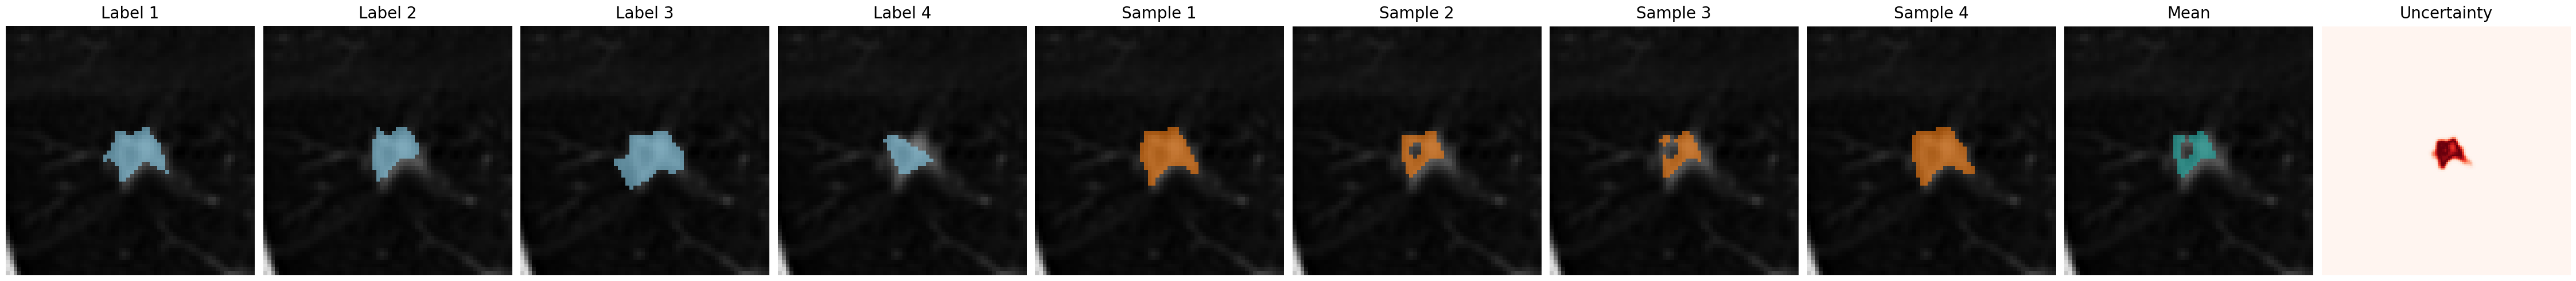

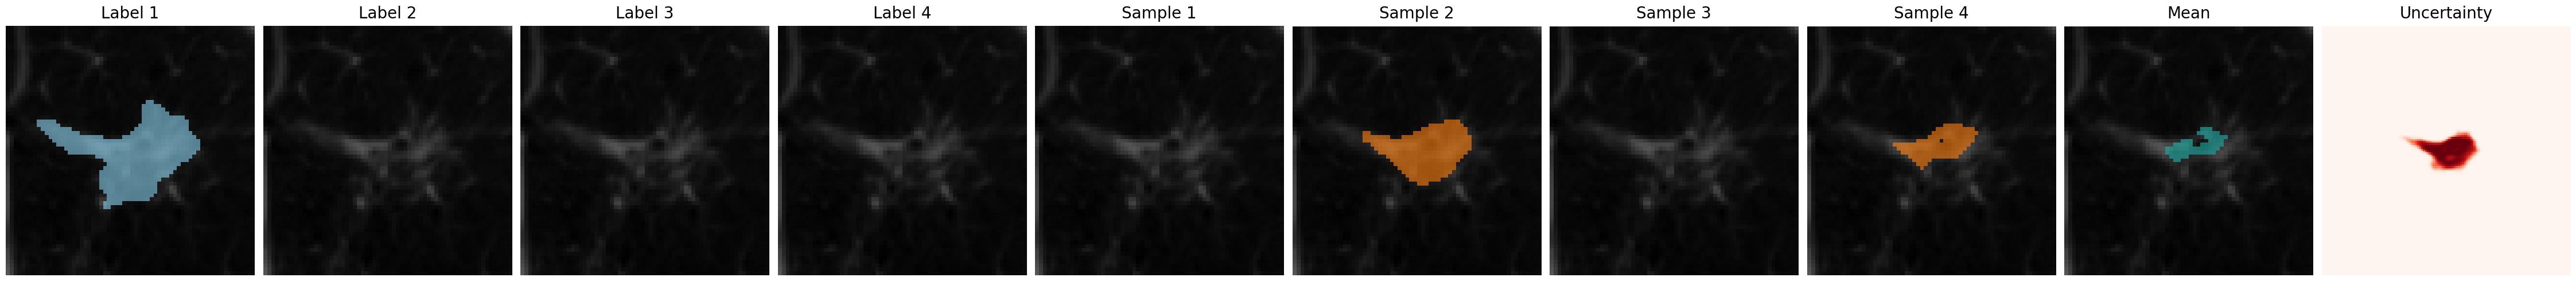

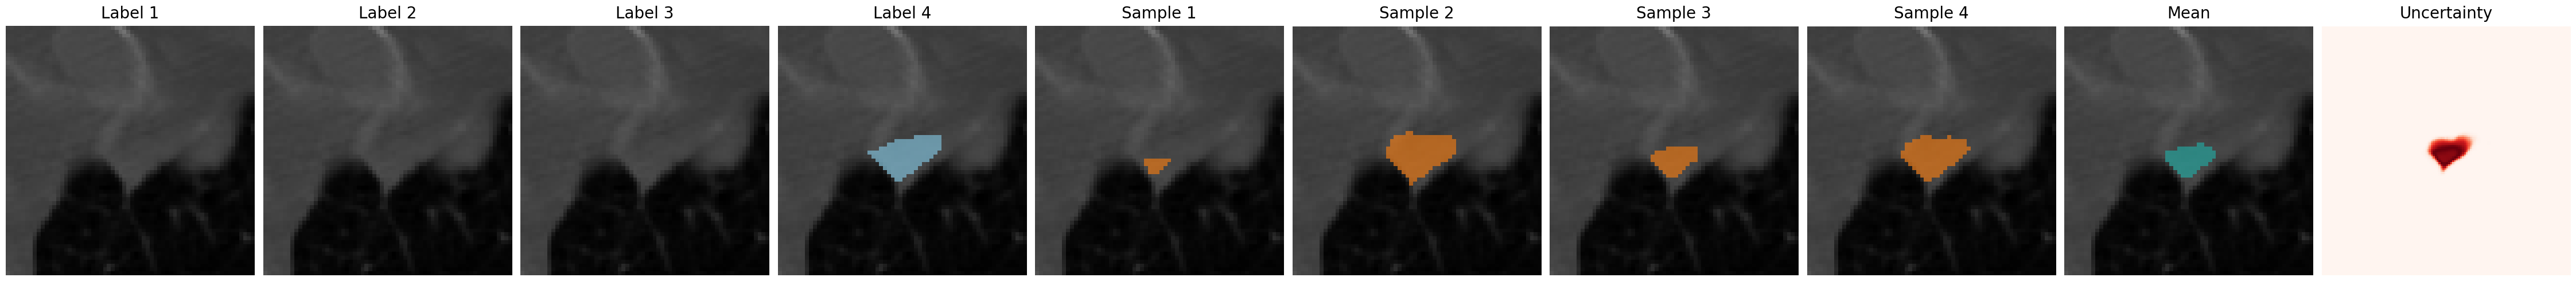

In [24]:
import numpy as np
import matplotlib.pyplot as plt

taborange = (1.0, 127/255, 14/255)
skyblue = (0.529, 0.808, 0.922)
light_sea_green = (32 / 255, 178 / 255, 170 / 255)

def get_overlay(
    mask: torch.Tensor, 
    img: torch.Tensor, 
    rgb: tuple[float, float, float], 
    alpha: float = 0.6
):
    color_mask = torch.zeros_like(img)
    for i in range(3):
        color_mask[..., i] = mask * rgb[i]
    overlay = img.clone()
    nonzero = mask > 0
    overlay[nonzero] = (1 - alpha) * img[nonzero] + alpha * color_mask[nonzero]
    return torch.clamp(overlay, 0, 1)

batch = next(iter(dataloader))
batch = preprocess_lidc_fn(batch, device=device)
with torch.no_grad():
    out = model.forward({"x": batch["x"]}, model.eval_samples)
    probs = out["logits"].softmax(dim=-1) # type: ignore

for _ in range(3):
    b = np.random.randint(batch["x"].shape[0])
    n = 10
    fig, ax = plt.subplots(1, n, figsize=(n * 5 - 5, 5))
    img = (batch["x"][b].permute(1, 2, 0).cpu() + 1) * 0.5
    o = 32
    img = img[o:128-o, o:128-o].repeat(1, 1, 3)

    for i in range(4):
        mask = batch["y_all"][b, :, :, i][o:128-o, o:128-o].cpu()
        overlay = get_overlay(mask, img, skyblue)
        ax[i].imshow(overlay)
        ax[i].axis("off")

    for i in range(4, n - 2):
        mask = probs.argmax(-1)[i][b][o:128-o, o:128-o].cpu()
        overlay = get_overlay(mask, img, taborange)
        ax[i].imshow(overlay)

    mean = torch.mean(probs[:, b,...], dim=0)
    uncertainty = -torch.sum(mean * torch.log(mean + 1e-12), dim=-1)
    overlay = get_overlay(mean.argmax(-1)[o:128-o, o:128-o].cpu(), img, light_sea_green)
    ax[-2].imshow(overlay)
    out = (uncertainty / uncertainty.max()).unsqueeze(0).repeat(1, 1, 1)    
    ax[-1].imshow(out.clamp(min=0).permute(1, 2, 0).cpu().numpy(), cmap="Reds")

    for i in range(n):
        ax[i].axis("off")

    for i in range(4):
        ax[i].set_title(f"Label {i+1}", fontsize=20, pad=10)
        ax[4+i].set_title(f"Sample {i+1}", fontsize=20, pad=10)

    ax[-2].set_title(f"Mean", fontsize=20, pad=10)
    ax[-1].set_title(f"Uncertainty", fontsize=20, pad=10)
    plt.tight_layout()